In [17]:
;pwd

/Users/Jorge/projects/Apophis/notebooks


In [18]:
]activate ..

In [19]:
using Revise

In [20]:
using Apophis

In [21]:
# using TaylorIntegration, LinearAlgebra # Apophis.jl @reexports TaylorIntegration and LinearAlgebra
using Plots, DelimitedFiles, Dates
using Statistics: mean, std
using AstroTime
using Printf

In [22]:
using JLD
#recover integration from .jld file
vars = ["tv1", "xv1", "tvS1", "xvS1", "gvS1"] #names of variables
#filename = string("Apophis_jt.jld")
#filename = string("Apophis_jt_J3_only_Ceres.jld")
filename = string("Apophis_jt_sseph.jld")
for i in eachindex(vars)
    ex = Symbol(vars[i])
    @eval $ex = load($filename, vars[$i])
end
const t0 = tv1[1]

2.4547335e6

In [23]:
ss16asteph = load(joinpath(Apophis.jplephpath, "ss16ast343_eph.jld"), "ss16ast_eph")
#__ss16asteph = load(joinpath(jplephpath, "ss16ast343_eph.jld"), "ss16ast_eph")
#t_eph = __ss16asteph.t
#x_eph = __ss16asteph.x

TaylorInterpolant{Float64,Float64,2}([2.45473e6, 2.45473e6, 2.45474e6, 2.45474e6, 2.45474e6, 2.45474e6, 2.45474e6, 2.45474e6, 2.45474e6, 2.45475e6  …  2.45655e6, 2.45655e6, 2.45655e6, 2.45655e6, 2.45655e6, 2.45656e6, 2.45656e6, 2.45656e6, 2.45656e6, 2.45656e6], Taylor1{Float64}[ - 0.001540802671596496 - 6.109751994756004e-6 t + 2.026639522818685e-9 t² + 1.1438549666017164e-11 t³ + 2.008120891468282e-14 t⁴ - 6.397903870966028e-16 t⁵ - 3.0546306184890543e-17 t⁶ - 9.68722980500796e-19 t⁷ - 2.0412821696633376e-20 t⁸ - 1.6045624661096607e-22 t⁹ + 9.159439581949366e-24 t¹⁰ + 5.598877087394386e-25 t¹¹ + 1.8283862308784619e-26 t¹² + 3.7475881410372636e-28 t¹³ + 1.3495214638455266e-30 t¹⁴ - 2.994615441437578e-31 t¹⁵ - 1.2942283714776832e-32 t¹⁶ - 2.9167496329057355e-34 t¹⁷ - 1.3718888576904797e-35 t¹⁸ - 3.966274892595813e-37 t¹⁹ + 5.73768668565269e-39 t²⁰ + 9.200379702713571e-40 t²¹ + 1.7317586297313006e-40 t²² + 3.324574435806996e-44 t²³ - 1.0350869147121307e-42 t²⁴ - 1.3403539294422135e-45 t²

In [9]:
apophis_radar_data_2005_2013 = process_radar_data_jpl("../Apophis_JPL_data.dat");

In [10]:
apophis_data = apophis_radar_data_2005_2013[6:end] #take only the 2012-2013 subset

29-element Array{RadarDataJPL{Float64},1}:
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2012-12-21T11:10:00, NaN, NaN, "X", 57992.443, 0.25, "Hz", 8560.0, 253, 253, "C")               
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2012-12-22T11:00:00, 1.0268298605e8, 0.25, "us", 57880.25, 0.1, "Hz", 8560.0, 253, 253, "C")    
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T09:20:00, 9.744910761e7, 0.25, "us", 36629.285, 0.1, "Hz", 8560.0, 253, 253, "C")    
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T10:00:00, 9.743930871e7, 3.0, "us", NaN, NaN, "X", 8560.0, 253, 253, "C")            
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-03T10:50:00, 9.742842546e7, 0.25, "us", NaN, NaN, "X", 8560.0, 253, 253, "C")           
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-05T08:40:00, NaN, NaN, "X", 30404.009, 0.2, "Hz", 8560.0, 253, 253, "C")                
 RadarDataJPL{Float64}("99942 Apophis (2004 MN4)", 2013-01-05T10:40:0

In [11]:
#monostatic mode: check that each receiver and transmitter are the same
@show all( ismonostatic.(apophis_data) )

all(ismonostatic.(apophis_data)) = true


true

In [12]:
#then, get the station codes
station_codes = [x.rcvr for x in apophis_data];

In [13]:
#extract transmitter frequencies (MHz)
transmitter_freq_MHz = [x.freq for x in apophis_data]

29-element Array{Float64,1}:
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
    ⋮  
 8560.0
 8560.0
 8560.0
 8560.0
 8560.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0
 2380.0

In [14]:
# get UTC receive times
tv_jpl_utc_jul = [datetime2julian(x.utcepoch) for x in apophis_data];

Let $\vec R$ denote the geocentric position of the observing station, $\vec \rho$ the topocentric position of the asteroid relative to the same station,  $\vec r_\mathrm{a}$ the geocentric position of the asteroid and $\vec r_\mathrm{E}$ the geocentric position of the asteroid. Then we have

$$
\vec r_\mathrm{a} =\vec r_\mathrm{E} + \vec R + \vec \rho
$$

Thus, the instantaneous topocentric range $\rho = |\vec \rho|$ of the asteroid may be computed as

$$
\rho = |\vec r_\mathrm{a} - \vec r_\mathrm{E} - \vec R| = \sqrt{(x_\mathrm{a} - x_\mathrm{E} - X)^2+(y_\mathrm{a} - y_\mathrm{E} - Y)^2+(z_\mathrm{a} - z_\mathrm{E} - Z)^2}
$$

And the instantaneous range rate $\dot \rho$ may be computed as:

$$
\dot \rho = \frac{1}{\rho}\vec{\rho} \cdot \dot{\vec{\rho}}
$$

# Delay/Doppler observations reduction

In [15]:
niters = 3 # number of iterations in time delay recursive process
rad_ind = 2

2

In [16]:
station_codes[rad_ind]

253

In [17]:
UTCEpoch.(TDBEpoch.(tv1, origin=:julian))

30-element Array{Epoch{UTC,Float64},1}:
 2008-09-23T23:58:54.818 UTC 
 2012-12-21T11:10:00.000 UTC 
 2012-12-22T11:00:00.000 UTC 
 2013-01-03T09:19:59.1000 UTC
 2013-01-03T10:00:00.000 UTC 
 2013-01-03T10:49:59.1000 UTC
 2013-01-05T08:39:59.1000 UTC
 2013-01-05T10:40:00.000 UTC 
 2013-01-05T10:50:00.000 UTC 
 2013-01-06T08:20:00.000 UTC 
 2013-01-06T09:29:59.1000 UTC
 2013-01-08T08:10:00.000 UTC 
 2013-01-09T07:59:59.1000 UTC
 ⋮                           
 2013-01-14T09:50:00.000 UTC 
 2013-01-15T06:30:00.000 UTC 
 2013-01-16T06:29:59.1000 UTC
 2013-01-16T07:49:59.1000 UTC
 2013-01-17T06:19:59.1000 UTC
 2013-02-18T00:56:00.000 UTC 
 2013-02-18T01:37:00.000 UTC 
 2013-02-19T01:07:59.1000 UTC
 2013-02-20T00:37:59.1000 UTC
 2013-02-20T01:26:00.000 UTC 
 2013-02-21T01:03:59.1000 UTC
 2013-03-15T23:58:59.1000 UTC

In [18]:
apophis_data[rad_ind].utcepoch

2012-12-22T11:00:00

In [ ]:
tdelay, dshift = delay_doppler(
    xv1[rad_ind+1, :],
    apophis_data[rad_ind].rcvr,
    apophis_data[rad_ind].utcepoch,
    apophis_data[rad_ind].freq,
    niters
)

In [ ]:
tdelay_jpl, dshift_jpl = delay_doppler_jpleph(
    apophis_data[rad_ind].rcvr,
    apophis_data[rad_ind].utcepoch,
    apophis_data[rad_ind].freq,
    niters
)

In [ ]:
apophis_data[rad_ind].delay #DELAY observed value

In [ ]:
tdelay_jpl #DELAY computed value, JPL

In [ ]:
apophis_data[rad_ind].delay - tdelay_jpl #DELAY O-C, JPL

In [ ]:
tdelay() #DELAY computed value, TaylorIntegration.jl, with A2=0

In [ ]:
apophis_data[rad_ind].delay - tdelay() #DELAY O-C, TaylorIntegration, with A2=0

In [ ]:
apophis_data[rad_ind].delay - tdelay(-5.6844) #DELAY O-C, TaylorIntegration, with A2=-5.7

In [ ]:
apophis_data[rad_ind].doppler #DOPPLER observed value

In [ ]:
dshift_jpl #DOPPLER computed value, JPL

In [ ]:
apophis_data[rad_ind].doppler - dshift_jpl #DOPPLER O-C, JPL

In [ ]:
dshift() #DOPPLER computed value, TaylorIntegration.jl, with A2=0

In [ ]:
apophis_data[rad_ind].doppler - dshift() #DELAY O-C, TaylorIntegration, with A2=0

In [ ]:
apophis_data[rad_ind].doppler - dshift(-5.6844) #DELAY O-C, TaylorIntegration, with A2=-5.7

In [ ]:
#get time-delay, Doppler-shift values from integration

tdelay_v1 = Array{Taylor1{Float64}}(undef, length(apophis_data))
dshift_v1 = Array{Taylor1{Float64}}(undef, length(apophis_data))

for i in eachindex(apophis_data)
    tdelay_v1[i], dshift_v1[i] = delay_doppler(
        xv1[i+1, :],
        apophis_data[i].rcvr,
        apophis_data[i].utcepoch,
        apophis_data[i].freq,
        niters
    )
end

__tdelay_v1 = tdelay_v1
__dshift_v1 = dshift_v1;

In [ ]:
# compute time-delay, Doppler-shift values from JPL ephemerides

tdelay_JPL_v1 = Array{Float64}(undef, length(apophis_data))
dshift_JPL_v1 = Array{Float64}(undef, length(apophis_data))
#dscoro_JPL_v1 = Array{Float64}(undef, length(apophis_data))

for i in eachindex(apophis_data)
    #tdelay_JPL_v1[i], dshift_JPL_v1[i], dscoro_JPL_v1[i] = delay_doppler_jpleph(
    tdelay_JPL_v1[i], dshift_JPL_v1[i] = delay_doppler_jpleph(
        apophis_data[i].rcvr,
        apophis_data[i].utcepoch,
        apophis_data[i].freq,
        niters
    )
end

# Time-delay / Doppler shift plots

In [ ]:
delay_index = findall(x->x.delay_units=="us", apophis_data)
doppler_index = findall(x->x.doppler_units=="Hz", apophis_data);

In [ ]:
tdelay_jpl_obs = [x.delay for x in apophis_data][delay_index]
dshift_jpl_obs = [x.doppler for x in apophis_data][doppler_index]

tdelay_jpl_obs_sigma = [x.delay_sigma for x in apophis_data][delay_index]
dshift_jpl_obs_sigma = [x.doppler_sigma for x in apophis_data][doppler_index];

In [ ]:
# Observed minus computed (O-C) residuals: JPL DE430+s199

# absolute
residual_JPL_td = tdelay_jpl_obs - tdelay_JPL_v1[delay_index]  # (usec)
residual_JPL_ds = dshift_jpl_obs - dshift_JPL_v1[doppler_index] # (Hz)

# relative
rel_res_JPL_td = residual_JPL_td ./ tdelay_jpl_obs # (usec)
rel_res_JPL_ds = residual_JPL_ds ./ dshift_jpl_obs # (Hz)
;

In [ ]:
residual_JPL_td

In [ ]:
residual_JPL_ds

dscoro_JPL_v1

scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    -1e6dscoro_JPL_v1[doppler_index]
    #residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    #marker=:xcross,
    #label = "JPL DE430+s199",
    #legend=:topleft
)
ylims!(0.0, 0.4)

In [ ]:
dshift_v1 == __dshift_v1, tdelay_v1 == __tdelay_v1

In [ ]:
#Observed minus computed (O-C) residuals: TaylorIntegration.jl

tdelay_v1 = __tdelay_v1
dshift_v1 = __dshift_v1

#tdelay_v1 = __tdelay_v1 - (__tdelay_v1() - tdelay_JPL_v1)
#dshift_v1 = __dshift_v1 - (__dshift_v1() - dshift_JPL_v1)

#absolute
residual_td = tdelay_jpl_obs - (tdelay_v1[delay_index])  # (usec)
residual_ds = dshift_jpl_obs - (dshift_v1[doppler_index]) # (Hz)

#residual_td = tdelay_jpl_obs[3:end] - (tdelay_v1[1:end-5][delay_index[1:end-2]])  # (usec)
#residual_ds = dshift_jpl_obs[6:end] - (dshift_v1[1:end-5][doppler_index[1:end-5]]) # (Hz)

#relative
rel_res_td = residual_td ./ tdelay_jpl_obs # (usec)
rel_res_ds = residual_ds ./ dshift_jpl_obs # (Hz)

#rel_res_td = residual_td ./ tdelay_jpl_obs[3:end] # (usec)
#rel_res_ds = residual_ds ./ dshift_jpl_obs[6:end] # (Hz)

;

## Plots

In [ ]:
A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[delay_index].-t0, tdelay_v1[delay_index](A2_plot),
    label="predicted (TaylorIntegration, A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    tdelay_JPL_v1[delay_index],
    label="predicted (JPL DE430+s199)",
    marker=:xcross
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    tdelay_jpl_obs,
    label="observed (Goldstone, Arecibo 2012-2013)",
    legend=:topleft,
    marker=:circle,
    markersize=3,
    yerror=dshift_jpl_obs_sigma
)
title!("Time delay vs time")
ylabel!("Total time delay [useconds]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[doppler_index].-t0, dshift_v1[doppler_index](A2_plot),
    label="predicted (TaylorIntegration, A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    dshift_JPL_v1[doppler_index],
    label="predicted (JPL DE430+s199)",
    marker=:xcross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    dshift_jpl_obs,
    label="observed (Goldstone, Arecibo 2012-2013)",
    legend=:topright,
    marker=:circle,
    markersize=3,
    yerror=dshift_jpl_obs_sigma
)
title!("Doppler shift vs time")
ylabel!("Total Doppler shift [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_lsqfit_deldop

In [ ]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.690389761808757 #-5.689728457397552 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(A2_plot), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    legend = :topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :topright
)
title!("Time delay residuals (O-C)")
ylabel!("Total time delay resid. (O-C) [us]")
xlims!(1540, 1645)
#ylims!(-215,210)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#savefig("delay_residuals_A2_0.pdf")
#savefig("delay_residuals_A2_lsfit.pdf")

In [ ]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.690389761808757 #-5.689728457397552 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_td(A2_plot), yerror = tdelay_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    legend = :topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :topright
)
title!("Time delay residuals (O-C)")
ylabel!("Total time delay resid. (O-C) [us]")
xlims!(1540, 1645)
#ylims!(-215,210)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#savefig("delay_residuals_A2_0.pdf")
#savefig("delay_residuals_A2_lsfit.pdf")

In [ ]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.690389761808757 #-5.689728457397552 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(A2_plot), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    leg=false
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:topleft
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#ylims!(-0.4,1.2)
#savefig("doppler_residuals_A2_0.pdf")
#savefig("doppler_residuals_A2_lsfit.pdf")

In [ ]:
#A2_plot = -5.592839897872 # JPL solution #199
A2_plot = -5.690389761808757 #-5.689728457397552 # A2_lsqfit_deldop
#A2_plot = 0.0 #-5.7
A2_label_str = @sprintf "TaylorIntegration (A2 = %.5f x 10^-14 au/d^2)"  A2_plot
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_ds(A2_plot), yerror = dshift_jpl_obs_sigma,
    marker=:cross,
    label = A2_label_str,
    leg=false
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:topleft
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
#ylims!(-0.4,1.2)
#savefig("doppler_residuals_A2_0.pdf")
#savefig("doppler_residuals_A2_lsfit.pdf")

In [ ]:
scatter(
    #tv_jpl_utc_jul[delay_index][1:end-3].-t0, residual_JPL_td[1:end-3], yerror = tdelay_jpl_obs_sigma[1:end-3],
    #tv_jpl_utc_jul[delay_index][end-3:end].-t0, residual_JPL_td[end-3:end], yerror = tdelay_jpl_obs_sigma[end-3:end],
    tv_jpl_utc_jul[delay_index].-t0, residual_JPL_td, yerror = tdelay_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend = :topright,
    color=2
)
ylabel!("Total time delay resid. (O-C) [us]")
#xlims!(1540, 1645)
#xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("Time delay residuals (O-C)")

In [ ]:
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    residual_JPL_ds, yerror = dshift_jpl_obs_sigma,
    marker=:xcross,
    label = "JPL DE430+s199",
    legend=:bottomright,
    color=2
)
title!("Doppler shift residuals (O-C)")
ylabel!("Total Doppler shift resid. (O-C) [Hz]")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    rel_res_JPL_td,
    yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="JPL DE430+s199",
    marker=:xcross,
    legend=:topright,
    color=2
)
title!("Time delay relative resid. (O-C)/O")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    rel_res_JPL_ds,
    yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="JPL DE430+s199",
    legend=:bottomright,
    marker=:xcross,
    color=2
)
title!("Doppler shift relative resid. (O-C)/O")
xlims!(1540, 1645)
#ylims!(-1e-7, 1e-7)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_plot = 0.0 #A2_lsqfit_del
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    rel_res_td(A2_plot),
    yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="TaylorIntegration (A2 = $A2_plot x 10^-14 au/d^2)",
    marker=:cross,
    legend=:topright
)
scatter!(
    tv_jpl_utc_jul[delay_index].-t0,
    rel_res_JPL_td,
    yerror = tdelay_jpl_obs_sigma./tdelay_jpl_obs,
    label="JPL DE430+s199",
    marker=:xcross,
    legend=:topright
)
title!("Time delay relative resid. (O-C)/O")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_plot = 0.0
scatter(
    tv_jpl_utc_jul[doppler_index].-t0,
    rel_res_ds(A2_plot),
    yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="TaylorIntegration (A2 = $A2_plot x 10^-14 au/d^2)",
    legend=:bottomright,
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[doppler_index].-t0,
    rel_res_JPL_ds,
    yerror = dshift_jpl_obs_sigma./dshift_jpl_obs,
    label="JPL DE430+s199",
    legend=:bottomright,
    marker=:xcross
)
title!("Doppler shift relative resid. (O-C)/O")
xlims!(1540, 1645)
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

#check that HORIZONS (s#199) and downloaded SPK file for Apophis are the same
#according to this check, they differ at the end of the evaluated times by ~ 2m in position
tv_spkvhor = range(2454733.5, length=1001, stop=2456367.5)
apophis_spk_arr = Array{Float64}(undef, length(tv_spkvhor), 6)
for i in eachindex(tv_spkvhor)
    apophis_spk_arr[i,:] .= Apophis.apophis_pv(tv_spkvhor[i])
end
apophis_horizons_arr = readdlm("../wld103954.15")
@show norm((apophis_spk_arr .- apophis_horizons_arr)[end,1:3])
@show norm((apophis_spk_arr .- apophis_horizons_arr)[end,4:6])
;

# Yarkovsky $A_2$ coefficient estimation

Here, we will compute, for a single time delay observation, the value of $A_2$ which makes the O-C residual of that observation equal to zero:

In [ ]:
#observed value
tdelay_jpl_obs[1]

In [ ]:
# computed value (full solution)
tdelay_v1[delay_index[1]] # τ_c(A2) = p(A2)

In [ ]:
# residual (A2 = 0)
tdelay_jpl_obs[1] - tdelay_v1[delay_index[1]]()

In [ ]:
# substract A2=0 solution from τ_c(A2) (i.e., compute τ_c(A2)-τ_c(A2=0) )
p_τ_1 = tdelay_v1[delay_index[1]]-tdelay_v1[delay_index[1]]()

In [ ]:
# Let p_τ_1(A2) be the above polynomial expression, then we invert it so we get A2(δτ):
A2_δτ_1 = inverse(p_τ_1)

In [ ]:
#Now, we evaluate the polynomial at the corresponding residual at the A2=0 TaylorIntegration solution:
A2_δτ_1(residual_td[1]())

Now, we follow the same strategy for all the 2012-2013 radar astrometry for Apohpis (delay and Doppler):

In [ ]:
td_us = tdelay_v1[delay_index]
ds_Hz = dshift_v1[doppler_index];

In [ ]:
A2_δτ_v = (  inverse.( td_us-td_us() )  ) # vector of A2(δτ) polynomials at each delay observation;
A2_δν_v = (  inverse.( ds_Hz-ds_Hz() )  ) # vector of A2(δν) polynomials at each Doppler observation;

In [ ]:
A2_del_v = map((x,y)->x(y), A2_δτ_v, residual_td()); # A2(δτ) polynomials evaluated at the O-C time delay residuals;
A2_dop_v = map((x,y)->x(y), A2_δν_v, residual_ds()); # A2(δν) polynomials evaluated at the O-C Doppler shift residuals;

In [ ]:
A2_del_v

In [ ]:
A2_dop_v

In [ ]:
mean(A2_del_v), std(A2_del_v)

In [ ]:
mean(A2_dop_v), std(A2_dop_v)

In [ ]:
A2_all = vcat(A2_del_v, A2_dop_v)

In [ ]:
A2_mean_all = mean(A2_all)
A2_std_all = std(A2_all)
A2_mean_all, A2_std_all

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    A2_del_v[1:end-3],
    marker=:cross,
    label="A2 est. (Goldstone delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    A2_del_v[end-2:end],
    marker=:xcross,
    label="A2 est. (Arecibo delay obs.)",
    color=3
)
ylabel!("A2(dt) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
scatter(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    A2_dop_v[1:end-7],
    marker=:cross,
    label="A2 est. (Goldstone Doppler obs.)",
    color=2
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    A2_dop_v[end-6:end],
    marker=:xcross,
    label="A2 est. (Arecibo Doppler obs.)",
    leg=:bottomleft,
    color=4
)
ylabel!("A2(df) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    A2_del_v[1:end-3],
    marker=:cross,
    label="A2 est. (Goldstone delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    A2_dop_v[1:end-7],
    marker=:cross,
    label="A2 est. (Goldstone Doppler obs.)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    A2_del_v[end-2:end],
    marker=:xcross,
    label="A2 est. (Arecibo delay obs.)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    A2_dop_v[end-6:end],
    marker=:xcross,
    label="A2 est. (Arecibo Doppler obs.)",
    leg=:bottomleft
)
ylabel!("A2 x 10^14 [au/d^2]")
xlims!(1540, 1645)
ylims!(-105,5)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_NO_Arecibo_dop = vcat(A2_del_v, A2_dop_v[1:end-7]);

In [ ]:
A2_mean_NO_Arecibo_dop = mean(A2_NO_Arecibo_dop)
A2_std_NO_Arecibo_dop = std(A2_NO_Arecibo_dop)
A2_mean_NO_Arecibo_dop, A2_std_NO_Arecibo_dop

# Intervals

In [ ]:
using IntervalArithmetic

In [ ]:
residual_td_interval = interval.(
    (tdelay_jpl_obs-tdelay_jpl_obs_sigma)-tdelay_v1[delay_index](), 
    (tdelay_jpl_obs+tdelay_jpl_obs_sigma)-tdelay_v1[delay_index]()
);

In [ ]:
residual_ds_interval = interval.(
    (dshift_jpl_obs-dshift_jpl_obs_sigma)-dshift_v1[doppler_index](),
    (dshift_jpl_obs+dshift_jpl_obs_sigma)-dshift_v1[doppler_index]()
);

In [ ]:
A2_del_v_interval = map((x,y)->x(y), A2_δτ_v, residual_td_interval)

In [ ]:
A2_dop_v_interval = map((x,y)->x(y), A2_δν_v, residual_ds_interval)

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    label="delay (Goldstone)",
    leg=:topright,
    marker=:cross
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    label="delay (Arecibo)",
    leg=:topright,
    marker=:xcross,
    color=3
)
#ylims!(minimum(A2_del_v)-1,0)
ylabel!("A2(dt) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("A2 estimation from polynomial inversion of delay obs.")
#savefig("A2_poly_inv_delay.pdf")

In [ ]:
scatter(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    label="Doppler (Goldstone)",
    marker=:cross,
    color=2
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    label="Doppler (Arecibo)",
    marker=:xcross,
    leg=:bottomleft,
    color=4
)
ylabel!("A2(df) x 10^14 [au/d^2]")
xlims!(1540, 1645)
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")

In [ ]:
A2_v_NO_Arecibo_dop_interval = vcat(A2_del_v_interval, A2_dop_v_interval[1:end-7])

In [ ]:
A2_mean_NO_Arecibo_dop_interval = mean(A2_v_NO_Arecibo_dop_interval)
A2_std_NO_Arecibo_dop_interval = std(A2_v_NO_Arecibo_dop_interval)
A2_mean_NO_Arecibo_dop_interval, A2_std_NO_Arecibo_dop_interval

## Least squares

In [ ]:
res_del = tdelay_jpl_obs .- tdelay_v1[delay_index]
res_dop = dshift_jpl_obs .- dshift_v1[doppler_index]
res_deldop = vcat(res_del, res_dop)
res_sq_del = res_del.^2
res_sq_dop = res_dop.^2
res_sq_deldop = res_deldop.^2
res_sq_deldop_NO_Arecibo_dop = vcat(res_sq_del, res_sq_dop[1:end-7]); #remove Arecibo Doppler "outliers"

In [ ]:
function taylor_minimum(pol::Taylor1{T}, x0::T; niters::Int=10) where {T<:Real}
    dpol = differentiate(pol)
    dpol2 = differentiate(dpol)
    xnewton::T = x0
    #@show xnewton
    for i in 1:niters
        xnewton -= dpol(xnewton)/dpol2(xnewton) 
        #@show xnewton, dpol(xnewton)
    end
    return xnewton
end

function taylor_roots(pol::Taylor1{T}, x0::T; niters::Int=10) where {T<:Real}
    dpol = differentiate(pol)
    xnewton::T = x0
    #@show xnewton
    for i in 1:niters
        xnewton -= pol(xnewton)/dpol(xnewton) 
        #@show xnewton, pol(xnewton)
    end
    return xnewton
end

In [ ]:
taylor_roots.(res_del, 0.0)

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index].-t0,
    taylor_roots.(res_del, 0.0),
    yerror=radius.(A2_del_v_interval)
)

In [ ]:
Q_A2_del = sum(res_sq_del)/length(res_sq_del)

In [ ]:
Q_A2_dop = sum(res_sq_dop)/length(res_sq_dop)

In [ ]:
Q_A2_deldop = sum(res_sq_deldop)/length(res_sq_deldop)

In [ ]:
Q_A2_deldop_NO_Arecibo_dop = sum(res_sq_deldop_NO_Arecibo_dop)/length(res_sq_deldop_NO_Arecibo_dop)

In [ ]:
A2_lsqfit_del = taylor_minimum(Q_A2_del, 0.0, niters=5)

In [ ]:
A2_lsqfit_dop = taylor_minimum(Q_A2_dop, 0.0, niters=5)

In [ ]:
A2_lsqfit_deldop = taylor_minimum(Q_A2_deldop, 0.0, niters=5)

In [ ]:
A2_lsqfit_deldop_NO_Arecibo_dop = taylor_minimum(Q_A2_deldop_NO_Arecibo_dop, 0.0, niters=5)

In [ ]:
A2_vals = range(-5.9, length=2000, stop=-5.5)

In [ ]:
plot(A2_vals, Q_A2_deldop.(A2_vals), leg=false)
xlabel!("A2 x 10^14 [au/day^2]")
ylabel!("Q(A2) [units?]")
title!("LS cost/loss function vs A2")
ylims!(-1, 11)
xlims!(-5.9, -5.5)

In [ ]:
mean(res_deldop), std(res_deldop)

In [ ]:
taylor_roots(mean(res_deldop), A2_lsqfit_deldop)

Check that the vector of residuals evaluated at the LS solution has mean zero:

In [ ]:
mean(res_deldop()), std(res_deldop()) #A2 = 0

In [ ]:
# A2 = A2 LS solution
mean(res_deldop(A2_lsqfit_deldop)), std(res_deldop(A2_lsqfit_deldop))

In [ ]:
# A2 such that res. mean is closest to zero
mean(res_deldop(-5.660727167817118)), std(res_deldop(-5.660727167817118))

If we expand the "cost" function Q wrt the solution value, then the first-order term should be zero:

In [ ]:
ΔQ = Q_A2_del(A2_lsqfit_del+Taylor1(Q_A2_del.order))-Q_A2_deldop(A2_lsqfit_del)

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    marker=:cross,
    leg=:bottomleft,
    label="delay (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    marker=:cross,
    label="Doppler (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    marker=:xcross,
    leg=:bottomleft,
    label="delay (Arecibo)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    marker=:xcross,
    label="Doppler (Arecibo)"
)
A2_label_str = @sprintf "A2 (fit): %.5f  x 10^-14 au/d^2" A2_lsqfit_deldop
plot!([1540, 1640], [A2_lsqfit_deldop, A2_lsqfit_deldop], label=A2_label_str)
ylabel!("A2 x 10^14 [au/day^2]")
xticks!(1540:20:1640, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1640)))))
xlabel!("Time")
title!("A2 estimation from radar astrometry (Brozovic et al., 2018)")
#savefig("A2_fit_all.pdf")

In [ ]:
scatter(
    tv_jpl_utc_jul[delay_index][1:end-3].-t0,
    mid.(A2_del_v_interval[1:end-3]),
    yerror=radius.(A2_del_v_interval[1:end-3]),
    marker=:cross,
    leg=:bottomleft,
    label="delay (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][1:end-7].-t0,
    mid.(A2_dop_v_interval[1:end-7]),
    yerror=radius.(A2_dop_v_interval[1:end-7]),
    marker=:cross,
    label="Doppler (Goldstone)"
)
scatter!(
    tv_jpl_utc_jul[delay_index][end-2:end].-t0,
    mid.(A2_del_v_interval[end-2:end]),
    yerror=radius.(A2_del_v_interval[end-2:end]),
    marker=:xcross,
    leg=:bottomright,
    label="delay (Arecibo)"
)
scatter!(
    tv_jpl_utc_jul[doppler_index][end-6:end].-t0,
    mid.(A2_dop_v_interval[end-6:end]),
    yerror=radius.(A2_dop_v_interval[end-6:end]),
    marker=:xcross,
    label=""#"Doppler (Arecibo)"
)
A2_label_str = @sprintf "A2 (fit): %.5f  x 10^-14 au/d^2" A2_lsqfit_deldop_NO_Arecibo_dop
plot!([1540, 1645], [A2_lsqfit_deldop, A2_lsqfit_deldop], label=A2_label_str)
ylims!(-20,0)
ylabel!("A2 x 10^14 [au/day^2]")
xlims!(1540, 1645)
xlabel!("Time")
xticks!(1540:20:1645, string.(Date.(julian2datetime.(t0 .+ collect(1540:20:1645)))))
title!("A2 estimation from radar astrometry (Brozovic et al., 2018)")
#savefig("A2_fit_no_Arecibo_doppler.pdf")

- Compare directly ephemerides JPL vs TaylorIntegration
- Propagate A2 interval trough March 2021 approach to see what difference in us, hz expect from A2 not zero

## Ephemerides: DE430+s199 vs TaylorIntegration

In [24]:
#function jd12(jd)
#    jd1 = floor(jd)+0.5 # Julian date at 0 h UT
#    jd2 = jd-jd1
#    return [jd1, jd2]
#end

function secs_since_j2000(jd)
    return (jd-Apophis.J2000)*Apophis.daysec
end

secs_since_j2000 (generic function with 1 method)

In [25]:
tv1_et = Array{Float64}(undef, length(tv1))
apophis_jpl = Array{Float64}(undef, length(tv1), 6)
earth_jpl = Array{Float64}(undef, length(tv1), 6)
for i in eachindex(tv1)
    tv1_et[i] = secs_since_j2000(tv1[i])
    apophis_jpl[i,:] .= Apophis.apophis_pv(tv1_et[i])
    earth_jpl[i,:] .= Apophis.earth_pv(tv1_et[i])
end

In [26]:
apophis_ti = xv1[:, 1:6](-5.690389761808757)
earth_ti = [ss16asteph(tv1[i])[j] for i in eachindex(tv1), j in union(3*4-2:3*4,3*(27+4)-2:3*(27+4))];

In [28]:
(apophis_ti - apophis_jpl) #*1000*au

30×6 Array{Float64,2}:
 -1.11022e-16   1.11022e-16  -2.77556e-17  …  -1.04083e-17  -8.67362e-19
  0.000406809  -2.86939e-5   -1.26493e-7       6.80475e-6    2.52871e-6 
  0.00040631   -2.1956e-5     2.37612e-6       6.76521e-6    2.51147e-6 
  0.000391911   5.56317e-5    3.10109e-5       6.22294e-6    2.28294e-6 
  0.00039186    5.58045e-5    3.10743e-5       6.22156e-6    2.28238e-6 
  0.000391797   5.60205e-5    3.11535e-5   …   6.21983e-6    2.28166e-6 
  0.000388152   6.78074e-5    3.54733e-5       6.12396e-6    2.24219e-6 
  0.000387986   6.83176e-5    3.56601e-5       6.11973e-6    2.24045e-6 
  0.000387972   6.83601e-5    3.56756e-5       6.11938e-6    2.24031e-6 
  0.000386138   7.38216e-5    3.76742e-5       6.07371e-6    2.22156e-6 
  0.000386036   7.41168e-5    3.77821e-5   …   6.07122e-6    2.22054e-6 
  0.000381797   8.58245e-5    4.20599e-5       5.97073e-6    2.17939e-6 
  0.000379503   9.1728e-5     4.42137e-5       5.91876e-6    2.15815e-6 
  ⋮                         

In [14]:
1000au*(apophis_ti - apophis_jpl)

30×6 Array{Float64,2}:
      -1.66087e-5        1.66087e-5  …     -1.55707e-6     -1.29755e-7
      -2.79636e5      6585.85           -4526.03        -1688.2       
      -2.79536e5      2101.41           -4505.41        -1678.76      
      -2.72409e5    -49904.9            -4194.93        -1544.11      
      -2.7238e5     -50021.4            -4194.09        -1543.76      
      -2.72344e5    -50167.0         …  -4193.04        -1543.31      
      -2.70247e5    -58118.6            -4134.16        -1518.63      
      -2.7015e5     -58463.0            -4131.54        -1517.54      
      -2.70142e5    -58491.7            -4131.32        -1517.45      
      -2.69068e5    -62180.0            -4102.93        -1505.6       
      -2.69009e5    -62379.4         …  -4101.38        -1504.95      
      -2.66492e5    -70293.1            -4038.19        -1478.68      
      -2.65113e5    -74286.9            -4005.16        -1465.0       
       ⋮                             ⋱                

In [15]:
1000au*(apophis_ti - apophis_jpl)

30×6 Array{Float64,2}:
      -1.66087e-5        1.66087e-5  …     -1.55707e-6     -1.29755e-7
      -2.79636e5      6585.85           -4526.03        -1688.2       
      -2.79536e5      2101.41           -4505.41        -1678.76      
      -2.72409e5    -49904.9            -4194.93        -1544.11      
      -2.7238e5     -50021.4            -4194.09        -1543.76      
      -2.72344e5    -50167.0         …  -4193.04        -1543.31      
      -2.70247e5    -58118.6            -4134.16        -1518.63      
      -2.7015e5     -58463.0            -4131.54        -1517.54      
      -2.70142e5    -58491.7            -4131.32        -1517.45      
      -2.69068e5    -62180.0            -4102.93        -1505.6       
      -2.69009e5    -62379.4         …  -4101.38        -1504.95      
      -2.66492e5    -70293.1            -4038.19        -1478.68      
      -2.65113e5    -74286.9            -4005.16        -1465.0       
       ⋮                             ⋱                

In [16]:
1000au*(earth_ti - earth_jpl)

30×6 Array{Float64,2}:
   0.00126226    0.00658483   -4.93071e-5  …   0.00046712  -0.000224088
 -11.0926        5.73432      12.25            0.479888    -3.75166    
 -12.9553        6.06266       8.35008         0.181494    -4.07057    
  -7.62364     -10.7014      -12.7203         -1.86153      2.75888    
  -7.55339     -10.753       -12.6434         -1.85181      2.78104    
  -7.46533     -10.8171      -12.5464      …  -1.8395       2.80863    
  -1.92163     -13.3923       -5.83655        -0.882706     4.07791    
  -1.69831     -13.4636       -5.49501        -0.830335     4.11907    
  -1.67972     -13.4694       -5.46639        -0.825936     4.12244    
   1.11851     -13.8206       -1.55193        -0.213701     4.47059    
   1.23944     -13.8302       -1.33428     …  -0.179202     4.48386    
   5.74064     -12.6618        7.62081         1.21165      4.47752    
   7.21039     -11.0365       11.9218          1.79954      4.03079    
   ⋮                                     

In [44]:
x_ae_ti = apophis_ti - earth_ti;

In [45]:
x_ae_jpl = apophis_jpl-earth_jpl;

In [47]:
r(x,y,z) = sqrt(x^2 + y^2 + z^2)
vr(x,y,z,u,v,w) = (x*u + y*v + z*w)/r(x,y,z)

r_ae_ti = r.(x_ae_ti[:,1], x_ae_ti[:,2], x_ae_ti[:,3])
vr_ae_ti = vr.( x_ae_ti[:,1], x_ae_ti[:,2], x_ae_ti[:,3], x_ae_ti[:,4], x_ae_ti[:,5], x_ae_ti[:,6] )

r_ae_jpl = r.(x_ae_jpl[:,1], x_ae_jpl[:,2], x_ae_jpl[:,3])
vr_ae_jpl = vr.( x_ae_jpl[:,1], x_ae_jpl[:,2], x_ae_jpl[:,3], x_ae_jpl[:,4], x_ae_jpl[:,5], x_ae_jpl[:,6] );

In [48]:
julian2datetime.( tv1[2:end])

29-element Array{DateTime,1}:
 2012-12-21T11:11:07.184
 2012-12-22T11:01:07.184
 2013-01-03T09:21:07.184
 2013-01-03T10:01:07.184
 2013-01-03T10:51:07.184
 2013-01-05T08:41:07.184
 2013-01-05T10:41:07.184
 2013-01-05T10:51:07.184
 2013-01-06T08:21:07.184
 2013-01-06T09:31:07.184
 2013-01-08T08:11:07.184
 2013-01-09T08:01:07.184
 2013-01-09T09:21:07.184
 ⋮                      
 2013-01-14T09:51:07.184
 2013-01-15T06:31:07.184
 2013-01-16T06:31:07.184
 2013-01-16T07:51:07.184
 2013-01-17T06:21:07.184
 2013-02-18T00:57:07.185
 2013-02-18T01:38:07.185
 2013-02-19T01:09:07.185
 2013-02-20T00:39:07.185
 2013-02-20T01:27:07.185
 2013-02-21T01:05:07.185
 2013-03-16T00:00:07.186

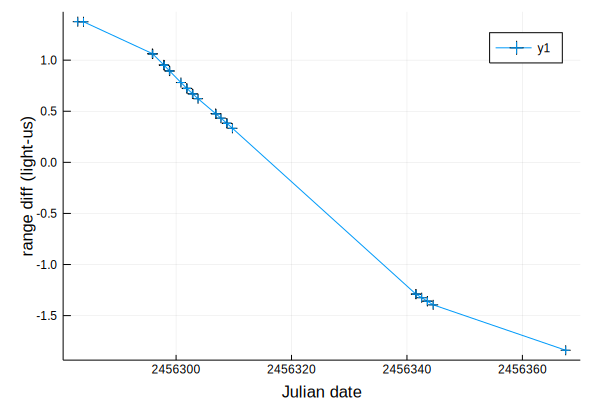

In [52]:
plot(tv1[2:end], 1e6*86400(r_ae_jpl[2:end]-r_ae_ti[2:end])/c_au_per_day, m=:cross)
ylabel!("range diff (light-us)")
xlabel!("Julian date")

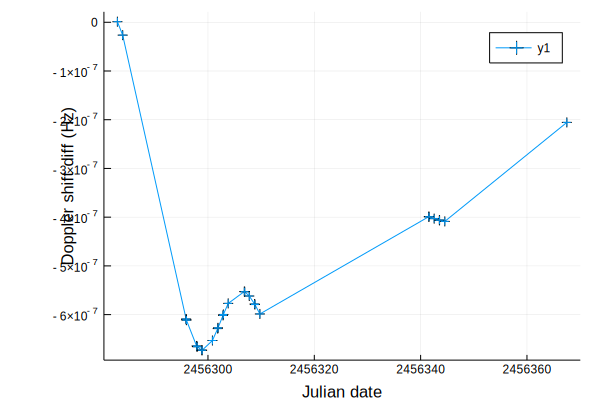

In [54]:
#plot(tv1[2:end], 1000au*(vr_ae_jpl[2:end]-vr_ae_ti[2:end])/86400, m=:cross)
plot(tv1[2:end], 1e6(vr_ae_jpl[2:end]-vr_ae_ti[2:end])/c_au_per_day, m=:cross)
ylabel!("Doppler shift diff (Hz)")
xlabel!("Julian date")

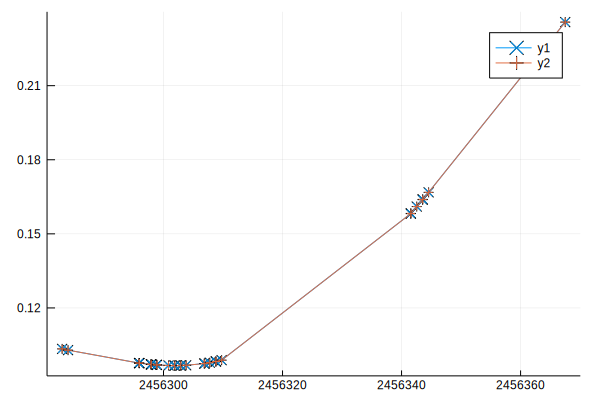

In [55]:
plot(tv1[2:end], (r_ae_ti[2:end]), m=:xcross)
plot!(tv1[2:end], (r_ae_jpl[2:end]), m=:cross)

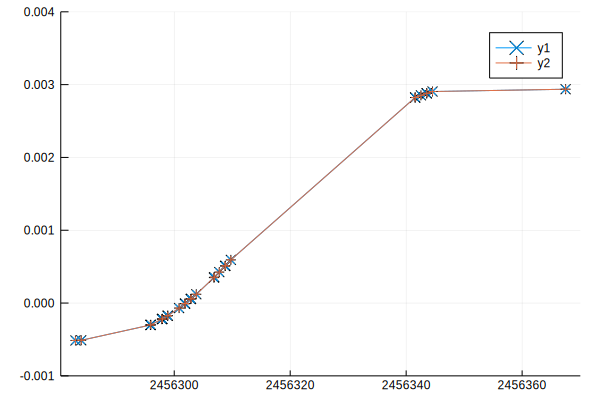

In [56]:
plot(tv1[2:end], (vr_ae_ti[2:end]), m=:xcross)
plot!(tv1[2:end], (vr_ae_jpl[2:end]), m=:cross)
ylims!(-0.001, 0.004)

In [59]:
au*(x_ae_ti - x_ae_jpl)./x_ae_jpl

30×6 Array{Float64,2}:
  6.59376e-7  -1.35039e-5   2.94484e-7  -3.70059e-5  1.68874e-5  -1.94974e-5
 -5.56718      0.781027    -0.214422     2.41089     5.04817     43.3814    
 -5.65797      1.01184     -0.361348     1.96021     5.22439     40.5708    
 -6.58192      2.97592     -1.6841      -3.05122     5.79953      0.263943  
 -6.58362      2.97868     -1.68465     -3.05809     5.79122      0.213646  
 -6.58575      2.98211     -1.68533     -3.06656     5.78073      0.151256  
 -6.69612      3.13669     -1.69251     -3.31963     5.04921     -2.42678   
 -6.70127      3.14202     -1.69175     -3.31968     5.01166     -2.49899   
 -6.7017       3.14245     -1.69168     -3.31963     5.00851     -2.50485   
 -6.75194      3.1891      -1.67792     -3.24907     4.58078     -3.06297   
 -6.75513      3.19132     -1.67706     -3.24163     4.55707     -3.08121   
 -6.89802      3.24505     -1.63826     -2.63229     3.62798     -2.82633   
 -6.98197      3.24858     -1.62491     -2.12448     

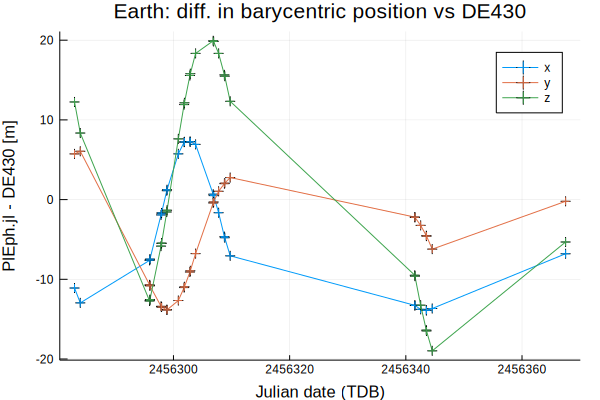

In [67]:
plot(tv1[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,1], label="x", marker=:cross)
plot!(tv1[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,2], label="y", marker=:cross)
plot!(tv1[2:end], 1000au*(earth_ti .- earth_jpl)[2:end,3], label="z", marker=:cross)
title!("Earth: diff. in barycentric position vs DE430")
ylabel!("PlEph.jl - DE430 [m]")
xlabel!("Julian date (TDB)")

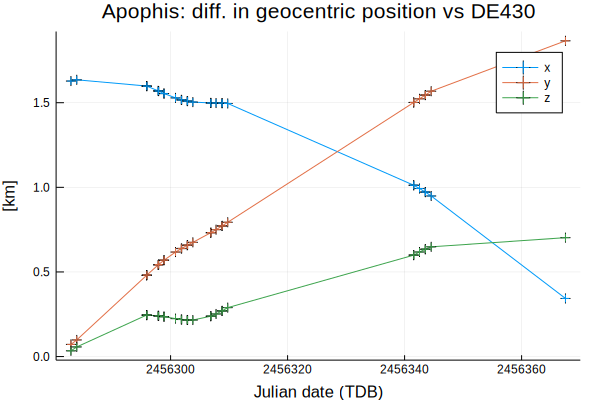

In [62]:
plot(tv1[2:end], (x_ae_ti - x_ae_jpl)[2:end,1]*au*(1e6/299792.458), label="x", marker=:cross)
plot!(tv1[2:end], (x_ae_ti - x_ae_jpl)[2:end,2]*au*(1e6/299792.458), label="y", marker=:cross)
plot!(tv1[2:end], (x_ae_ti - x_ae_jpl)[2:end,3]*au*(1e6/299792.458), label="z", marker=:cross)
title!("Apophis: diff. in geocentric position vs DE430")
ylabel!("[km]")
xlabel!("Julian date (TDB)")

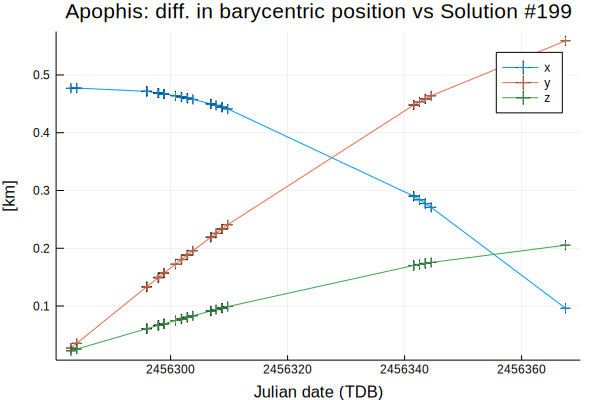

In [63]:
plot(tv1[2:end], (apophis_ti-apophis_jpl)[2:end,1]*au, label="x", marker=:cross)
plot!(tv1[2:end], (apophis_ti-apophis_jpl)[2:end,2]*au, label="y", marker=:cross)
plot!(tv1[2:end], (apophis_ti-apophis_jpl)[2:end,3]*au, label="z", marker=:cross)
title!("Apophis: diff. in barycentric position vs Solution #199")
ylabel!("[km]")
xlabel!("Julian date (TDB)")

## Propagation up to 2021/2038

#recover integration from .jld file

#using JLD

vars = ["tv1", "xv1", "tvS1", "xvS1", "gvS1"] #names of variables
vars_2038 = ["tv1_2038", "xv1_2038", "tvS1_2038", "xvS1_2038", "gvS1_2038"] #names of variables
filename_2038 = string("Apophis_2038_jt.jld")
for i in eachindex(vars)
    ex_2038 = Symbol(vars_2038[i])
    @eval $ex_2038 = load($filename_2038, vars[$i])
end

tv1_2038

apophis_TI_diff = xv1_2038[:, Apophis.apophisdofs](A2_lsqfit_deldop)-xv1_2038[:, Apophis.apophisdofs]();

ae_TI_0 = xv1_2038[:, Apophis.apophisdofs]()-xv1_2038[:, Apophis.earthdofs]()
d_Ap_Ea_0 = sqrt.(ae_TI_0[:,1].^2 + ae_TI_0[:,2].^2 + ae_TI_0[:,3].^2)

ae_TI_A2 = xv1_2038[:, Apophis.apophisdofs](A2_lsqfit_deldop)-xv1_2038[:, Apophis.earthdofs]()
d_Ap_Ea_A2 = sqrt.(ae_TI_A2[:,1].^2 + ae_TI_A2[:,2].^2 + ae_TI_A2[:,3].^2)
;

gr()

_2021_approach = 3200:3263
plot(tv1_2038[_2021_approach].-tv1_2038[3200], (d_Ap_Ea_A2-d_Ap_Ea_0)[_2021_approach].*au)

findfirst(x->x>datetime2julian(DateTime(2021,1,1)), tv1_2038)

findlast(x->x<datetime2julian(DateTime(2021,4,1)), tv1_2038)